### Лабораторная работа 2 ###
- выбрать датасет для классификации, например на kaggle;
- реализовать алгоритм KNN с методом окна Парзена переменной ширины;
- в качестве ядра можно использовать гауссово ядро;
- подобрать параметр k методом скользящего контроля (LOO);
- обосновать выбор параметров алгоритма, построить графики эмпирического риска для различных k;
- сравнить с эталонной реализацией KNN;
- сравнить качество работы;
- сравнить время работы;
- подготовить небольшой отчет о проделанной работе.

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import kagglehub

c:\Users\klimm\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Скачиваем датасет с ирисами Фишера с kaggle
path = kagglehub.dataset_download("uciml/iris")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\klimm\.cache\kagglehub\datasets\uciml\iris\versions\2


In [3]:
df = pd.read_csv("data/Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Преобразовываем целевую переменную в числовой формат
label_encoder = LabelEncoder()
df['Species'] = label_encoder.fit_transform(df['Species'])

# Удаляем столбец Id
df.drop(columns=['Id'], inplace=True)

# Разделяем на X и y
X = df.drop(columns=['Species']).values
y = df['Species'].values

In [5]:
from knn import loo_cross_validation, KNNParzenWindow, accuracy

In [6]:
# Генерируем значения k для перебора
k_values = range(1, 21)
bandwidths = [0.1, 0.5, 1.0, 2.0, 5.0]

# Выполненяем loo кросс-валидации с подбором параметров k и bandwidth
best_k, best_bandwidth, best_accuracy, results, execution_times = loo_cross_validation(X, y, k_values, bandwidths)

# Тестируем на всей выборке с оптимальными параметрами
knn = KNNParzenWindow(best_bandwidth)
knn.fit(X, y)
y_pred_all = knn.predict(X, best_k)
accuracy = accuracy(y, y_pred_all)
print(f'\nAccuracy with best parameters (bandwidth={best_bandwidth}, k={best_k}): {accuracy:.4f}')

Bandwidth: 0.1, k: 1, Error: 0.0400
Bandwidth: 0.1, k: 2, Error: 0.0400
Bandwidth: 0.1, k: 3, Error: 0.0400
Bandwidth: 0.1, k: 4, Error: 0.0400
Bandwidth: 0.1, k: 5, Error: 0.0400
Bandwidth: 0.1, k: 6, Error: 0.0400
Bandwidth: 0.1, k: 7, Error: 0.0400
Bandwidth: 0.1, k: 8, Error: 0.0400
Bandwidth: 0.1, k: 9, Error: 0.0400
Bandwidth: 0.1, k: 10, Error: 0.0400
Bandwidth: 0.1, k: 11, Error: 0.0400
Bandwidth: 0.1, k: 12, Error: 0.0400
Bandwidth: 0.1, k: 13, Error: 0.0400
Bandwidth: 0.1, k: 14, Error: 0.0400
Bandwidth: 0.1, k: 15, Error: 0.0400
Bandwidth: 0.1, k: 16, Error: 0.0400
Bandwidth: 0.1, k: 17, Error: 0.0400
Bandwidth: 0.1, k: 18, Error: 0.0400
Bandwidth: 0.1, k: 19, Error: 0.0400
Bandwidth: 0.1, k: 20, Error: 0.0400
Bandwidth: 0.5, k: 1, Error: 0.0400
Bandwidth: 0.5, k: 2, Error: 0.0400
Bandwidth: 0.5, k: 3, Error: 0.0400
Bandwidth: 0.5, k: 4, Error: 0.0400
Bandwidth: 0.5, k: 5, Error: 0.0333
Bandwidth: 0.5, k: 6, Error: 0.0400
Bandwidth: 0.5, k: 7, Error: 0.0400
Bandwidth: 0.5, k

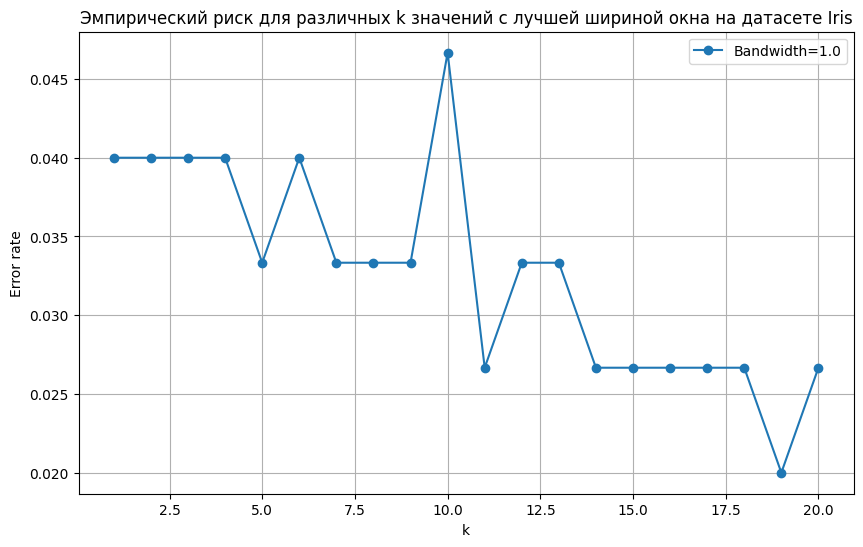

In [12]:
# Строим график ошибок для различных k с лучшим bandwidth
errors_best_bandwidth = results[best_bandwidth]
plt.figure(figsize=(10, 6))
plt.plot(k_values, errors_best_bandwidth, marker='o', label=f'Bandwidth={best_bandwidth}')
plt.xlabel('k')
plt.ylabel('Error rate')
plt.title('Эмпирический риск для различных k значений с лучшей шириной окна на датасете Iris')
plt.legend()
plt.grid(True)
plt.show()

### Выводы ###
Таким образом, была использована функция loo_cross_validation для нахождения оптимального k и bandwidth.
Как видно из итогов работы функции loo_cross_validation, оптимальное k = 19 при bandwidth = 1.0, при таком количестве соседей и ширине окна алгоритм работает лучше всего и выдает accuracy = 0.98

### Сравнение с эталонной реализацией KNN ###

In [8]:
from sklearn.neighbors import KNeighborsClassifier
import time

In [9]:
sklearn_errors = []
sklearn_accuracies = []
best_sklearn_accuracy = 0
best_sklearn_k = None
start_time_sklearn = time.time()

for k in k_values:
    error = 0
    correct = 0
    for i in range(len(X)):
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i, axis=0)
        X_test = X[i:i+1]
        y_test = y[i]
        
        sklearn_knn = KNeighborsClassifier(n_neighbors=k)
        sklearn_knn.fit(X_train, y_train)
        y_pred = sklearn_knn.predict(X_test)
        
        if y_pred == y_test:
            correct += 1
        else:
            error += 1
            
    current_accuracy = correct / len(X)
    current_error = error / len(X)
    
    sklearn_accuracies.append(current_accuracy)
    sklearn_errors.append(current_error)
    
    print(f'sklearn KNN - k: {k}, Accuracy: {current_accuracy:.4f}, Error: {current_error:.4f}')
    
    if current_accuracy > best_sklearn_accuracy:
        best_sklearn_accuracy = current_accuracy
        best_sklearn_k = k

sklearn_time = time.time() - start_time_sklearn

sklearn KNN - k: 1, Accuracy: 0.9600, Error: 0.0400
sklearn KNN - k: 2, Accuracy: 0.9467, Error: 0.0533
sklearn KNN - k: 3, Accuracy: 0.9600, Error: 0.0400
sklearn KNN - k: 4, Accuracy: 0.9600, Error: 0.0400
sklearn KNN - k: 5, Accuracy: 0.9667, Error: 0.0333
sklearn KNN - k: 6, Accuracy: 0.9600, Error: 0.0400
sklearn KNN - k: 7, Accuracy: 0.9667, Error: 0.0333
sklearn KNN - k: 8, Accuracy: 0.9667, Error: 0.0333
sklearn KNN - k: 9, Accuracy: 0.9667, Error: 0.0333
sklearn KNN - k: 10, Accuracy: 0.9733, Error: 0.0267
sklearn KNN - k: 11, Accuracy: 0.9733, Error: 0.0267
sklearn KNN - k: 12, Accuracy: 0.9600, Error: 0.0400
sklearn KNN - k: 13, Accuracy: 0.9667, Error: 0.0333
sklearn KNN - k: 14, Accuracy: 0.9733, Error: 0.0267
sklearn KNN - k: 15, Accuracy: 0.9733, Error: 0.0267
sklearn KNN - k: 16, Accuracy: 0.9667, Error: 0.0333
sklearn KNN - k: 17, Accuracy: 0.9733, Error: 0.0267
sklearn KNN - k: 18, Accuracy: 0.9733, Error: 0.0267
sklearn KNN - k: 19, Accuracy: 0.9800, Error: 0.0200
sk


Comparison of results:
KNNParzenWindow - Best k: 19, Best bandwidth: 1.0
Best accuracy: 0.9800
Execution time: 7.7227 seconds

sklearn KNN - Best k: 19
Best accuracy: 0.9800
Execution time: 10.9066 seconds


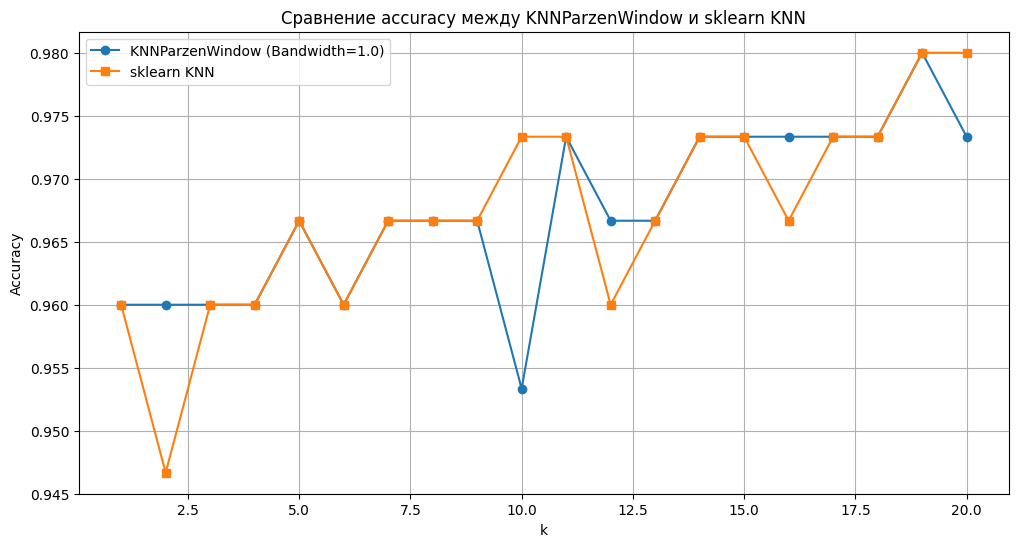

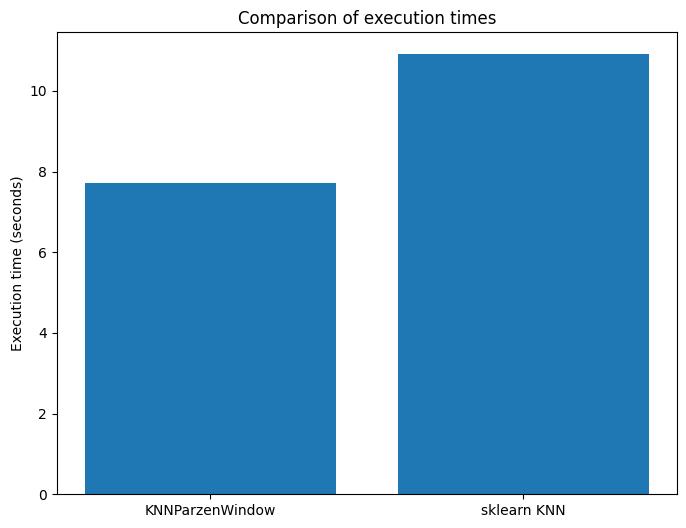

In [10]:
# Сравниваем результаты
print("\nComparison of results:")
print(f"KNNParzenWindow - Best k: {best_k}, Best bandwidth: {best_bandwidth}")
print(f"Best accuracy: {1 - best_accuracy:.4f}")
print(f"Execution time: {execution_times[best_bandwidth]:.4f} seconds")
print(f"\nsklearn KNN - Best k: {best_sklearn_k}")
print(f"Best accuracy: {best_sklearn_accuracy:.4f}")
print(f"Execution time: {sklearn_time:.4f} seconds")

# Строим графики для сравнения accuracy
plt.figure(figsize=(12, 6))
plt.plot(k_values, [1 - err for err in results[best_bandwidth]], marker='o', label=f'KNNParzenWindow (Bandwidth={best_bandwidth})')
plt.plot(k_values, sklearn_accuracies, marker='s', label='sklearn KNN')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Сравнение accuracy между KNNParzenWindow и sklearn KNN')
plt.legend()
plt.grid(True)
plt.show()

# Строим график времени выполнения
plt.figure(figsize=(8, 6))
plt.bar(['KNNParzenWindow', 'sklearn KNN'], 
        [execution_times[best_bandwidth], sklearn_time])
plt.ylabel('Execution time (seconds)')
plt.title('Comparison of execution times')
plt.show()